In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

# Data Cleaning and Preprocessing

In [2]:
#Read the data into a Data Frame

df = pd.read_excel('CTG.xls', sheet_name='Raw Data')

#remove the 3 lines indicating the total
df = df.dropna()

#remove irrelevant columns
df.drop(['FileName', 'Date', 'SegFile', 'b', 'e', 'LBE', 'DR', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP'], axis =1, inplace=True)
df = df.reset_index()
df.drop(['index'], axis =1, inplace=True)

df.to_csv('cleaned_data.csv', index=False)
df.columns


Index(['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency', 'CLASS', 'NSP'],
      dtype='object')

In [4]:
#seperating the data into features and classes

#Features excluding CLASS and NSP
X = np.asarray(df[df.columns[:-2]]).astype(np.float32)
y_class = np.asarray(df.CLASS).astype(np.int32)
y_nsp = np.asarray(df.NSP).astype(np.int32)

#Features including CLASS
X_with_class = np.asarray(df[df.columns[:-1]]).astype(np.float32)

#Features including NSP
col = ['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency','NSP']
temp = df[col]
X_with_nsp = np.asarray(temp).astype(np.float32)

#Splitting the data into training and test sets. 4 different sets are created.

#Spliting for the first group. X features excludes both CLASS and NSP and the label being predicted is CLASS
#for set 1
X_train1, X_test1, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.2, shuffle= True, random_state = 0)



#splitting for the 2nd group. X features excludes both CLASS and NSP and the label being predicted is NSP
#for set 2
X_train2, X_test2, y_nsp_train, y_nsp_test = train_test_split(X, y_nsp, test_size=0.2, shuffle= True, random_state = 0)


#splitting for the 3rd group. X features includes both CLASS and the label being predicted is NSP
#for set 3
X_train3, X_test3, y_nsp_train3, y_nsp_test3 = train_test_split(X_with_class, y_nsp, test_size=0.2, shuffle= True, random_state = 0)


#splitting for the 4th group. X features includes both NSP and the label being predicted is CLASS
#for set 4
X_train4, X_test4, y_class_train4, y_class_test4 = train_test_split(X_with_nsp, y_class, test_size=0.2, shuffle= True, random_state = 0)

# Data Exploration

<function matplotlib.pyplot.show(*args, **kw)>

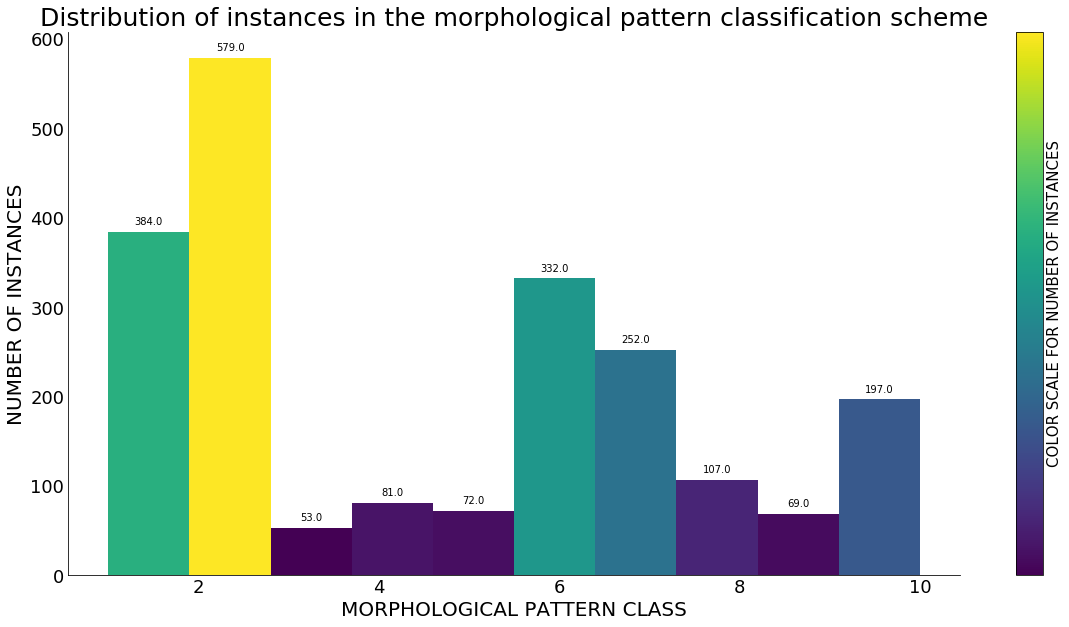

In [5]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
%matplotlib inline


#PLOT HISTOGRAM SHOWING THE DISTRIBUTION OF CLASSES WITHIN THE 10 CLASS

plt.figure(figsize=(20,10))
#colors = ['red', 'white', 'tan', 'white', 'lime', 'white', 'yellow', 'white', 'black', 'white', 'purple', 'white', 'green', 'white', 'blue', 'white', 'brown', 'white', 'orange', 'white']
N, bins, patches= plt.hist(y_class, bins =10)
#i = 0
#while i < 20:
#    patches[i].set_facecolor(colors[i])
#    i+=1
    
# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)    
plt.xlabel('MORPHOLOGICAL PATTERN CLASS', fontsize = 20)
plt.ylabel('NUMBER OF INSTANCES', fontsize = 20)
plt.title('Distribution of instances in the morphological pattern classification scheme', fontsize = 25)

ax = plt.gca()
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
    
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = y_value

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)
ax.tick_params(axis=u'both', which=u'both',length=0, labelsize=18)

cm = plt.cm.get_cmap('viridis')
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[])
cbar.set_label('COLOR SCALE FOR NUMBER OF INSTANCES', fontsize=15)


plt.savefig("image_class.png")
    
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

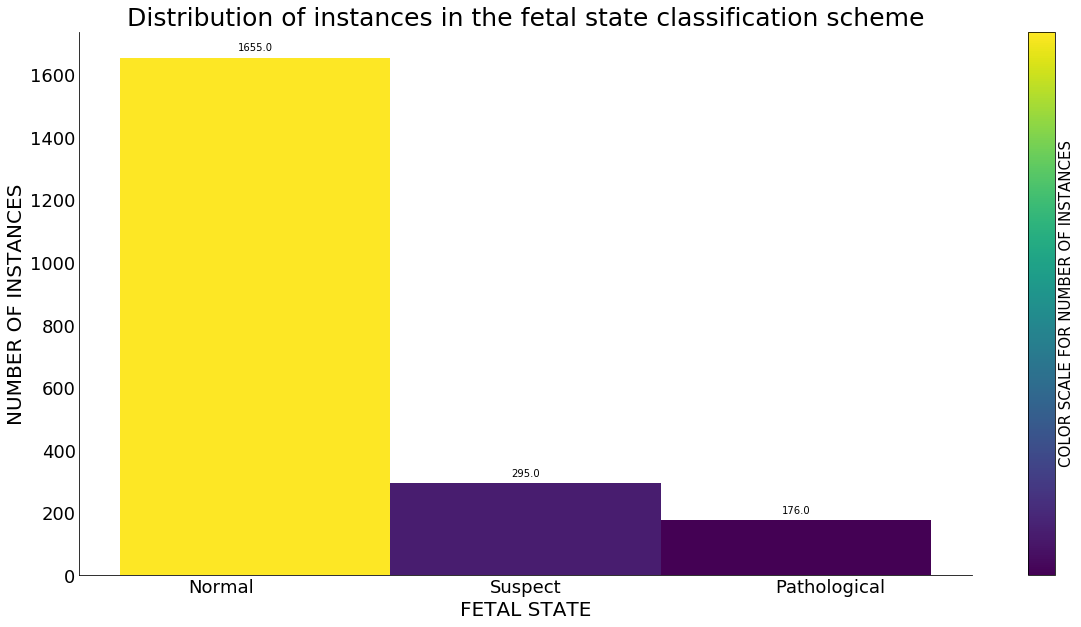

In [6]:
#PLOT HISTOGRAM SHOWING THE DISTRIBUTION OF CLASSES WITHIN THE 3 CLASSES (NSP)

plt.figure(figsize=(20,10))
#colors = ['red', 'white', 'tan', 'white', 'lime', 'white', 'yellow', 'white', 'black', 'white', 'purple', 'white', 'green', 'white', 'blue', 'white', 'brown', 'white', 'orange', 'white']
N, bins, patches= plt.hist(y_nsp, bins =3)
#i = 0
#while i < 20:
#    patches[i].set_facecolor(colors[i])
#    i+=1
    
# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)    
plt.xlabel('FETAL STATE', fontsize=20)
plt.ylabel('NUMBER OF INSTANCES', fontsize=20)
plt.title('Distribution of instances in the fetal state classification scheme', fontsize = 25)

ax = plt.gca()
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)


    
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = y_value

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)


a=['','','Normal','','','Suspect','','','Pathological','']
ax.set_xticklabels(a)
ax.tick_params(axis=u'both', which=u'both',length=0, labelsize=18)

cm = plt.cm.get_cmap('viridis')
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[])
cbar.set_label('COLOR SCALE FOR NUMBER OF INSTANCES', fontsize=15)

plt.savefig("image_nsp.png")
    
plt.show

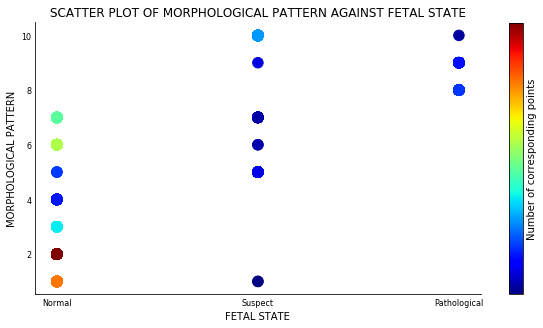

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm

plt.figure(figsize=(10,5))
samples = np.array([y_nsp,y_class])
densObj = kde( samples )

def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    norm = Normalize( vmin=vals.min(), vmax=vals.max() )

    #Can put any colormap you like here.
    colours = [cm.ScalarMappable( norm=norm, cmap='jet').to_rgba( val ) for val in vals]

    return colours

colours = makeColours( densObj.evaluate( samples ) )
cm = plt.cm.get_cmap('jet')

ax = plt.gca()

sc = ax.scatter( samples[0], samples[1], color=colours, s=110)

plt.xlabel("FETAL STATE")
plt.ylabel('MORPHOLOGICAL PATTERN')
plt.title('SCATTER PLOT OF MORPHOLOGICAL PATTERN AGAINST FETAL STATE')


ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

b=['','Normal','','','','Suspect','','','','Pathological']
ax.set_xticklabels(b)
ax.tick_params(axis=u'both', which=u'both',length=0, labelsize=8)

cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[])
cbar.ax.set_yticklabels(['','','','','',''])  # horizontal colorbar
cbar.set_label('Number of corresponding points')

plt.savefig("correlation.png")

(0.0, 38.00492858886719, 0.0, 65.09249114990234)

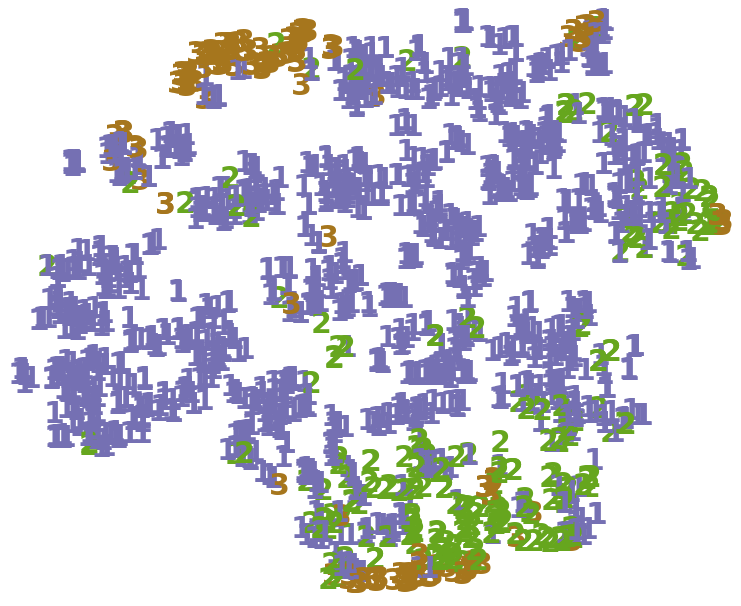

In [13]:
# Apply TSNE to compress the data into 2 dimensions to see the spatial relationships

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X = tsne.fit_transform(X_train1)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6, 5))
for i, t in enumerate(y_nsp_train):
    w = X[i]
    plt.text(w[0] + .5, w[1] + .5, str(t), color=plt.cm.Dark2(t / 4.),
             fontdict={'weight': 'bold', 'size': 30})
plt.axis([0, np.max(X[:, 0]), 0, np.max(X[:, 1])])
plt.axis('off')

In [14]:
data_scaler = StandardScaler()

X_train1 = data_scaler.fit_transform(X_train1)
X_train2 = data_scaler.fit_transform(X_train2)
X_train3 = data_scaler.fit_transform(X_train3)
X_train4 = data_scaler.fit_transform(X_train4)

X_test1 = data_scaler.fit_transform(X_test1)
X_test2 = data_scaler.fit_transform(X_test2)
X_test3 = data_scaler.fit_transform(X_test3)
X_test4 = data_scaler.fit_transform(X_test4)

# Support Vector Machine Classifier

In [57]:
# Creating a SVM classifier instance
svc = SVC()

#Calling the scaler
data_scaler = StandardScaler()

model = make_pipeline(data_scaler, svc)
param_grid = {'svc__C': [ 20, 30, 50, 100, 125, 150, 200],
              'svc__gamma': [ 0.01, 0.015, 0.02, 0.05]}


#Grid search for the best parameters while doing 5-fold cross validation
grid1 = GridSearchCV(model, param_grid, cv=5)
grid1.fit(X_train1, y_class_train)

grid2 = GridSearchCV(model,param_grid, cv=5)
grid2.fit(X_train2, y_nsp_train)

grid3 = GridSearchCV(model,param_grid, cv=5)
grid3.fit(X_train3, y_nsp_train3)

grid4 = GridSearchCV(model,param_grid, cv=5)
grid4.fit(X_train4, y_class_train4)
print( grid4.best_estimator_)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=150, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


In [58]:
# Selecting the best estimator after the parameter search

print(grid1.best_estimator_)
print(grid2.best_estimator_)
print(grid3.best_estimator_)
print(grid4.best_estimator_)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=200, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=125, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.015, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking

In [602]:
grid1.cv_results_['mean_test_score']

array([0.29411765, 0.69411765, 0.72352941, 0.75235294, 0.45352941,
       0.72705882, 0.76      , 0.78529412, 0.73      , 0.81411765,
       0.82705882, 0.83705882, 0.78529412, 0.82647059, 0.84117647,
       0.84411765, 0.8       , 0.84058824, 0.84294118, 0.85411765,
       0.81823529, 0.84470588, 0.84941176, 0.85294118, 0.81647059,
       0.84117647, 0.85882353, 0.85      ])

### Plotting a Confusion Matrix

In [597]:
# This function let you draw a confusion matrix for your problem

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('')

    #print(cm)
    
    plt.figure()

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [614]:
# Predicting the test labels
y_pred1 = grid1.predict(X_test1)
y_pred2 = grid2.predict(X_test2)
y_pred3 = grid3.predict(X_test3)
y_pred4 = grid4.predict(X_test4)

In [59]:
cv1_svm = cross_val_score(grid1, X_train1, y_class_train, cv=5)
cv2_svm = cross_val_score(grid2, X_train2, y_nsp_train, cv=5)
cv3_svm = cross_val_score(grid3, X_train3, y_nsp_train3, cv=5)
cv4_svm = cross_val_score(grid4, X_train4, y_class_train4, cv=5)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarn

In [618]:
print('cross validation for model 1: ', cv1_svm)
print('cross validation for model 2: ', cv2_svm)
print('cross validation for model 3: ', cv3_svm)
print('cross validation for model 4: ', cv4_svm)

cross validation for model 1:  [0.86918605 0.84795322 0.85294118 0.86430678 0.82686567]
cross validation for model 2:  [0.92668622 0.93841642 0.92647059 0.92058824 0.89940828]
cross validation for model 3:  [0.97653959 0.97360704 0.95588235 0.96764706 0.9704142 ]
cross validation for model 4:  [0.92732558 0.90643275 0.9        0.91740413 0.87761194]


In [15]:
cv1_svm = [0.86918605, 0.84795322, 0.85294118, 0.86430678, 0.82686567]
cv2_svm = [0.92668622, 0.93841642, 0.92647059, 0.92058824, 0.89940828]
cv3_svm = [0.97653959, 0.97360704, 0.95588235, 0.96764706, 0.9704142 ]
cv4_svm = [0.92732558, 0.90643275, 0.9, 0.91740413, 0.87761194]

In [844]:
np.array(cv3_MLP).mean()

0.96529378

              precision    recall  f1-score   support

           1       0.82      0.86      0.84        78
           2       0.91      0.93      0.92       114
           3       0.57      0.57      0.57         7
           4       0.84      0.94      0.89        17
           5       0.86      0.67      0.75        18
           6       0.84      0.86      0.85        63
           7       0.92      0.81      0.86        54
           8       0.92      0.92      0.92        25
           9       0.92      0.65      0.76        17
          10       0.72      0.85      0.78        33

   micro avg       0.86      0.86      0.86       426
   macro avg       0.83      0.81      0.81       426
weighted avg       0.86      0.86      0.86       426

              precision    recall  f1-score   support

      normal       0.95      0.96      0.96       326
     suspect       0.77      0.76      0.77        58
pathological       0.92      0.86      0.89        42

   micro avg       0.92

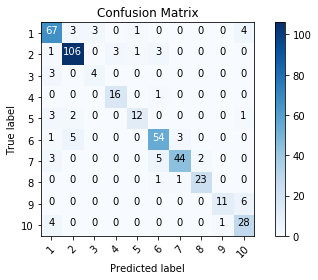

In [615]:
# Printing the classification report
target_names = ['normal', 'suspect', 'pathological']

print(classification_report(y_pred=y_pred1,y_true=y_class_test))
print(classification_report(y_pred=y_pred2,y_true=y_nsp_test,target_names=target_names))
print(classification_report(y_pred=y_pred3,y_true=y_nsp_test3,target_names=target_names))
print(classification_report(y_pred=y_pred4,y_true=y_class_test4))

confusion_mtx1 = confusion_matrix(y_class_test, y_pred1)
confusion_mtx2 = confusion_matrix(y_nsp_test, y_pred2)
confusion_mtx3 = confusion_matrix(y_nsp_test3, y_pred3)
confusion_mtx4 = confusion_matrix(y_class_test4, y_pred4)


print("model 1 accuracy= ",(confusion_mtx1.diagonal().sum()/confusion_mtx1.sum())*100)
print("model 2 accuracy= ",(confusion_mtx2.diagonal().sum()/confusion_mtx2.sum())*100)
print("model 3 accuracy= ",(confusion_mtx3.diagonal().sum()/confusion_mtx3.sum())*100)
print("model 4 accuracy= ",(confusion_mtx4.diagonal().sum()/confusion_mtx4.sum())*100)

plot_confusion_matrix(confusion_mtx1, ['1','2','3','4','5','6','7','8','9','10'])

# Naive Bayes Classifier

In [802]:
#Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score



def Naive_Bayes(Xtrain, ytrain, Xtest, ytest):
    NB_classifier = GaussianNB()
    
    cv_acc = cross_val_score(NB_classifier, Xtrain, ytrain, cv=5 )

    NB_classifier.fit(Xtrain,ytrain)
    
    y_pred = NB_classifier.predict(Xtest)
    
    confusion_mtx = confusion_matrix(ytest, y_pred)
    
    plot_confusion_matrix(confusion_mtx, [str(i) for i in range(1,len(confusion_mtx)+1)])
    
    accuracy = (confusion_mtx.diagonal().sum()/confusion_mtx.sum())*100
    
    return print(classification_report(y_pred = y_pred, y_true = ytest),'\n', 'cross validation accuracy =', cv_acc, '\n', 'test accuracy =', accuracy)




              precision    recall  f1-score   support

           1       0.73      0.53      0.61        78
           2       0.67      0.56      0.61       114
           3       0.40      0.57      0.47         7
           4       0.29      0.94      0.44        17
           5       0.39      0.61      0.48        18
           6       0.88      0.56      0.68        63
           7       0.83      0.72      0.77        54
           8       0.89      1.00      0.94        25
           9       0.34      0.71      0.46        17
          10       0.45      0.42      0.44        33

   micro avg       0.61      0.61      0.61       426
   macro avg       0.59      0.66      0.59       426
weighted avg       0.68      0.61      0.63       426
 
 cross validation accuracy = [0.67151163 0.59356725 0.58529412 0.61356932 0.5761194 ] 
 test accuracy = 61.267605633802816

              precision    recall  f1-score   support

           1       0.98      0.79      0.87       326
      

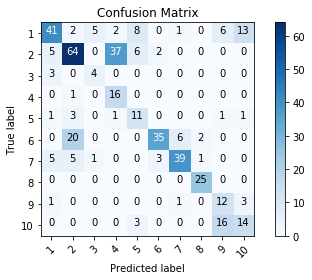

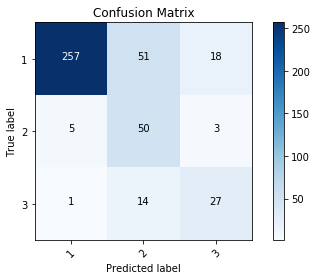

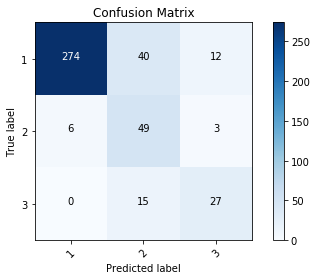

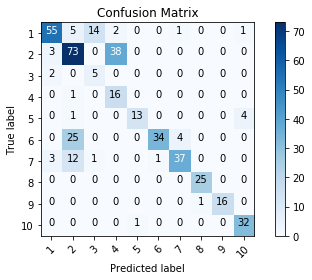

In [803]:
Naive_Bayes(X_train1, y_class_train, X_test1, y_class_test )

Naive_Bayes(X_train2, y_nsp_train, X_test2, y_nsp_test )

Naive_Bayes(X_train3, y_nsp_train3, X_test3, y_nsp_test3)

Naive_Bayes(X_train4, y_class_train4, X_test4, y_class_test4 )

In [16]:
cv1_NB = [0.67151163, 0.59356725, 0.58529412, 0.61356932, 0.5761194 ] 
cv2_NB = [0.79178886, 0.80645161, 0.82647059, 0.79411765, 0.81952663]
cv3_NB = [0.86510264, 0.85923754, 0.87058824, 0.82941176, 0.87869822]
cv4_NB = [0.73837209, 0.69298246, 0.72352941, 0.67846608, 0.69552239]

# Gradient Boosting Classifier

In [816]:
from sklearn.ensemble import GradientBoostingClassifier

def GradBoost(Xtrain, ytrain, Xtest, ytest):
    clf = GradientBoostingClassifier()
    
    #doing grid search for best parameters with a 5-fold cross validation
    parameters = {'max_depth':[2,3],
                  'n_estimators':[81,82,85],
                  'min_samples_split':[3,4],
                  'subsample':[0.9,1],
                  'learning_rate':[0.2],
                  'min_samples_leaf':[1,2,3,5]}
    clf = GridSearchCV(clf, parameters, cv=5)
    
    #fitting the data
    clf.fit(Xtrain,ytrain)
    
    #get an array of the cross validation scores for the best parameters
    cv_acc = cross_val_score(clf, Xtrain, ytrain, cv=5 )
    
    # Predicting the test labels
    y_pred = clf.predict(Xtest)
    
    
    #creating confusion matrix and plotting it
    confusion_mtx = confusion_matrix(ytest, y_pred)
    plot_confusion_matrix(confusion_mtx, [str(i) for i in range(1,len(confusion_mtx)+1)])

    accuracy = (confusion_mtx.diagonal().sum()/confusion_mtx.sum())*100
    
    return print(classification_report(y_pred = y_pred, y_true = ytest),
                 '\n', 'cross validation accuracy =',
                 cv_acc, '\n', 'test accuracy =',
                 accuracy)




              precision    recall  f1-score   support

           1       0.86      0.87      0.87        78
           2       0.91      0.93      0.92       114
           3       0.83      0.71      0.77         7
           4       0.88      0.82      0.85        17
           5       0.73      0.44      0.55        18
           6       0.84      0.89      0.86        63
           7       0.90      0.83      0.87        54
           8       0.96      1.00      0.98        25
           9       0.94      0.88      0.91        17
          10       0.84      0.97      0.90        33

   micro avg       0.88      0.88      0.88       426
   macro avg       0.87      0.84      0.85       426
weighted avg       0.88      0.88      0.87       426
 
 cross validation accuracy = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_de

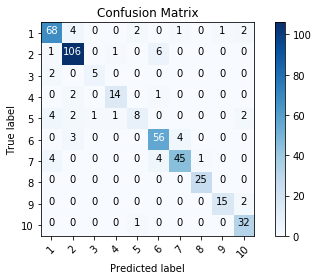

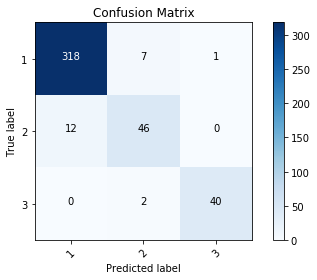

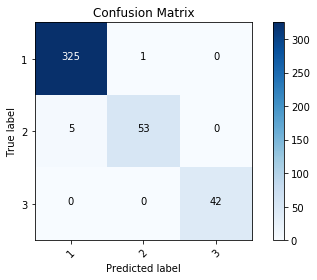

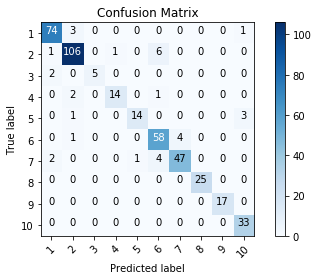

In [817]:
GradBoost(X_train1, y_class_train, X_test1, y_class_test )
GradBoost(X_train2, y_nsp_train, X_test2, y_nsp_test )
GradBoost(X_train3, y_nsp_train3, X_test3, y_nsp_test3 )
GradBoost(X_train4, y_class_train4, X_test4, y_class_test4 )

In [17]:
cv1_GB = [0.90988372, 0.90350877, 0.87941176, 0.92920354, 0.88656716]
cv2_GB = [0.96480938, 0.95307918, 0.94705882, 0.97352941, 0.96153846]
cv3_GB = [0.98826979, 0.9941349,  0.97941176, 0.99117647, 0.98816568]
cv4_GB = [0.92732558, 0.93859649, 0.91176471, 0.9439528,  0.92238806]

In [18]:
cv1_RF = [0.91569767, 0.89766082, 0.87941176, 0.92920354, 0.88059701]
cv2_RF = [0.96480938, 0.95014663, 0.92941176, 0.97058824, 0.96153846]
cv3_RF = [0.98533724, 0.98826979, 0.97058824, 0.98823529, 0.98816568]
cv4_RF = [0.94476744, 0.92105263, 0.91764706, 0.93510324, 0.91343284]

# Multi-Layer Perceptron Classifier

In [829]:
def mlp(Xtrain, ytrain, Xtest, ytest):
    from sklearn.neural_network import MLPClassifier
    
    #create an MLP with 4 hidden layer having 30 neurons
    mlp_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(30,30,30,30), max_iter=500, alpha=0.0001, batch_size=8,
                     solver='adam', verbose=1,  random_state=22, tol=0.00000000000000000001, validation_fraction=0.15, early_stopping=True, n_iter_no_change=100)
    
    mlp_clf.fit(Xtrain, ytrain)
    ypred = mlp_clf.predict(Xtest)
    
    #cv_acc = cross_val_score(mlp_clf, Xtrain, ytrain, cv=5 )
    cv_acc = 0

    confusion_mtx = confusion_matrix(ytest, ypred)
    
    plot_confusion_matrix(confusion_mtx, [str(i) for i in range(1,len(confusion_mtx)+1)])
    
    accuracy = (confusion_mtx.diagonal().sum()/confusion_mtx.sum())*100
    
    return print(classification_report(y_pred = ypred, y_true = ytest),'\n', 'cross validation accuracy =', cv_acc, '\n', 'test accuracy =', accuracy)

    

Iteration 1, loss = 1.86739394
Validation score: 0.639216
Iteration 2, loss = 0.93545291
Validation score: 0.792157
Iteration 3, loss = 0.60279725
Validation score: 0.811765
Iteration 4, loss = 0.46296036
Validation score: 0.839216
Iteration 5, loss = 0.38636032
Validation score: 0.850980
Iteration 6, loss = 0.33198534
Validation score: 0.862745
Iteration 7, loss = 0.29695442
Validation score: 0.874510
Iteration 8, loss = 0.27161436
Validation score: 0.878431
Iteration 9, loss = 0.25676257
Validation score: 0.886275
Iteration 10, loss = 0.24293765
Validation score: 0.874510
Iteration 11, loss = 0.22328814
Validation score: 0.890196
Iteration 12, loss = 0.21208243
Validation score: 0.905882
Iteration 13, loss = 0.19438243
Validation score: 0.890196
Iteration 14, loss = 0.18491130
Validation score: 0.890196
Iteration 15, loss = 0.17354385
Validation score: 0.882353
Iteration 16, loss = 0.17785853
Validation score: 0.882353
Iteration 17, loss = 0.17390043
Validation score: 0.878431
Iterat

Iteration 140, loss = 0.01849132
Validation score: 0.905882
Iteration 141, loss = 0.01922158
Validation score: 0.905882
Iteration 142, loss = 0.01463152
Validation score: 0.909804
Iteration 143, loss = 0.01650510
Validation score: 0.898039
Iteration 144, loss = 0.02654705
Validation score: 0.905882
Iteration 145, loss = 0.01364216
Validation score: 0.898039
Iteration 146, loss = 0.02429556
Validation score: 0.913725
Iteration 147, loss = 0.01526170
Validation score: 0.909804
Iteration 148, loss = 0.01543356
Validation score: 0.917647
Iteration 149, loss = 0.01598845
Validation score: 0.929412
Iteration 150, loss = 0.01667641
Validation score: 0.905882
Iteration 151, loss = 0.05491147
Validation score: 0.901961
Iteration 152, loss = 0.03589436
Validation score: 0.909804
Iteration 153, loss = 0.04180778
Validation score: 0.874510
Iteration 154, loss = 0.05129948
Validation score: 0.882353
Iteration 155, loss = 0.03030447
Validation score: 0.898039
Iteration 156, loss = 0.01866531
Validat

Iteration 26, loss = 0.13697561
Validation score: 0.887255
Iteration 27, loss = 0.12543090
Validation score: 0.887255
Iteration 28, loss = 0.12595518
Validation score: 0.887255
Iteration 29, loss = 0.12459715
Validation score: 0.887255
Iteration 30, loss = 0.11609001
Validation score: 0.872549
Iteration 31, loss = 0.11993346
Validation score: 0.872549
Iteration 32, loss = 0.10440975
Validation score: 0.857843
Iteration 33, loss = 0.10029778
Validation score: 0.857843
Iteration 34, loss = 0.10468588
Validation score: 0.897059
Iteration 35, loss = 0.11868831
Validation score: 0.877451
Iteration 36, loss = 0.09460540
Validation score: 0.872549
Iteration 37, loss = 0.10042877
Validation score: 0.862745
Iteration 38, loss = 0.10072717
Validation score: 0.872549
Iteration 39, loss = 0.08660407
Validation score: 0.882353
Iteration 40, loss = 0.08178036
Validation score: 0.852941
Iteration 41, loss = 0.08327761
Validation score: 0.877451
Iteration 42, loss = 0.08148248
Validation score: 0.8774

Iteration 18, loss = 0.14336782
Validation score: 0.887255
Iteration 19, loss = 0.14086381
Validation score: 0.877451
Iteration 20, loss = 0.14199231
Validation score: 0.887255
Iteration 21, loss = 0.13856797
Validation score: 0.877451
Iteration 22, loss = 0.12878297
Validation score: 0.872549
Iteration 23, loss = 0.12672632
Validation score: 0.882353
Iteration 24, loss = 0.11340606
Validation score: 0.887255
Iteration 25, loss = 0.10986867
Validation score: 0.882353
Iteration 26, loss = 0.11415717
Validation score: 0.887255
Iteration 27, loss = 0.10130186
Validation score: 0.862745
Iteration 28, loss = 0.10522784
Validation score: 0.882353
Iteration 29, loss = 0.09891391
Validation score: 0.887255
Iteration 30, loss = 0.09233232
Validation score: 0.867647
Iteration 31, loss = 0.10525213
Validation score: 0.906863
Iteration 32, loss = 0.08790073
Validation score: 0.872549
Iteration 33, loss = 0.08254112
Validation score: 0.911765
Iteration 34, loss = 0.07355999
Validation score: 0.8921

Iteration 156, loss = 0.00749509
Validation score: 0.877451
Iteration 157, loss = 0.00581749
Validation score: 0.887255
Iteration 158, loss = 0.00591099
Validation score: 0.887255
Iteration 159, loss = 0.00754643
Validation score: 0.892157
Iteration 160, loss = 0.00825349
Validation score: 0.887255
Iteration 161, loss = 0.00872974
Validation score: 0.882353
Iteration 162, loss = 0.00690383
Validation score: 0.892157
Iteration 163, loss = 0.00596216
Validation score: 0.892157
Iteration 164, loss = 0.00649075
Validation score: 0.882353
Iteration 165, loss = 0.04488668
Validation score: 0.872549
Iteration 166, loss = 0.08587807
Validation score: 0.882353
Iteration 167, loss = 0.01945425
Validation score: 0.882353
Validation score did not improve more than tol=0.000000 for 100 consecutive epochs. Stopping.
Iteration 1, loss = 1.99433478
Validation score: 0.598039
Iteration 2, loss = 1.09059417
Validation score: 0.710784
Iteration 3, loss = 0.66605515
Validation score: 0.764706
Iteration 4,

Iteration 127, loss = 0.03031929
Validation score: 0.916667
Iteration 128, loss = 0.01591403
Validation score: 0.921569
Iteration 129, loss = 0.01090837
Validation score: 0.916667
Iteration 130, loss = 0.01960923
Validation score: 0.911765
Iteration 131, loss = 0.01649828
Validation score: 0.911765
Iteration 132, loss = 0.01725227
Validation score: 0.911765
Iteration 133, loss = 0.01595215
Validation score: 0.916667
Iteration 134, loss = 0.01438896
Validation score: 0.901961
Iteration 135, loss = 0.01581700
Validation score: 0.901961
Iteration 136, loss = 0.01879095
Validation score: 0.921569
Iteration 137, loss = 0.01756414
Validation score: 0.906863
Iteration 138, loss = 0.02801963
Validation score: 0.911765
Iteration 139, loss = 0.08531499
Validation score: 0.901961
Iteration 140, loss = 0.09636691
Validation score: 0.921569
Iteration 141, loss = 0.04708909
Validation score: 0.901961
Iteration 142, loss = 0.01444795
Validation score: 0.916667
Iteration 143, loss = 0.00973308
Validat

Validation score: 0.906863
Iteration 264, loss = 0.00747052
Validation score: 0.906863
Iteration 265, loss = 0.01713295
Validation score: 0.901961
Iteration 266, loss = 0.00788669
Validation score: 0.901961
Iteration 267, loss = 0.00731816
Validation score: 0.901961
Iteration 268, loss = 0.00598000
Validation score: 0.897059
Iteration 269, loss = 0.00624359
Validation score: 0.897059
Iteration 270, loss = 0.00722070
Validation score: 0.901961
Iteration 271, loss = 0.00598269
Validation score: 0.901961
Iteration 272, loss = 0.00615191
Validation score: 0.897059
Iteration 273, loss = 0.00703814
Validation score: 0.897059
Iteration 274, loss = 0.00897220
Validation score: 0.901961
Iteration 275, loss = 0.00662931
Validation score: 0.901961
Iteration 276, loss = 0.00619924
Validation score: 0.906863
Iteration 277, loss = 0.01559448
Validation score: 0.906863
Iteration 278, loss = 0.05067266
Validation score: 0.897059
Iteration 279, loss = 0.05072580
Validation score: 0.901961
Iteration 280

Validation score: 0.906863
Iteration 402, loss = 0.00531623
Validation score: 0.901961
Iteration 403, loss = 0.00625258
Validation score: 0.906863
Iteration 404, loss = 0.00909041
Validation score: 0.906863
Iteration 405, loss = 0.00654422
Validation score: 0.901961
Iteration 406, loss = 0.00499654
Validation score: 0.906863
Iteration 407, loss = 0.00887617
Validation score: 0.897059
Iteration 408, loss = 0.08105218
Validation score: 0.892157
Iteration 409, loss = 0.02075799
Validation score: 0.916667
Iteration 410, loss = 0.02079382
Validation score: 0.916667
Iteration 411, loss = 0.02807803
Validation score: 0.906863
Iteration 412, loss = 0.01035167
Validation score: 0.906863
Iteration 413, loss = 0.00596737
Validation score: 0.906863
Iteration 414, loss = 0.00530691
Validation score: 0.911765
Iteration 415, loss = 0.00564906
Validation score: 0.906863
Iteration 416, loss = 0.00560583
Validation score: 0.911765
Iteration 417, loss = 0.00547132
Validation score: 0.916667
Iteration 418

Validation score: 0.897561
Iteration 100, loss = 0.01359265
Validation score: 0.897561
Iteration 101, loss = 0.01267723
Validation score: 0.887805
Iteration 102, loss = 0.02147182
Validation score: 0.887805
Iteration 103, loss = 0.01369213
Validation score: 0.907317
Iteration 104, loss = 0.02598216
Validation score: 0.892683
Iteration 105, loss = 0.04117595
Validation score: 0.902439
Iteration 106, loss = 0.02531959
Validation score: 0.892683
Iteration 107, loss = 0.01228020
Validation score: 0.892683
Iteration 108, loss = 0.01758142
Validation score: 0.892683
Iteration 109, loss = 0.01182782
Validation score: 0.902439
Iteration 110, loss = 0.02019409
Validation score: 0.897561
Iteration 111, loss = 0.02472542
Validation score: 0.912195
Iteration 112, loss = 0.02307262
Validation score: 0.887805
Iteration 113, loss = 0.08702317
Validation score: 0.882927
Iteration 114, loss = 0.10878005
Validation score: 0.912195
Iteration 115, loss = 0.03659030
Validation score: 0.902439
Iteration 116

Iteration 237, loss = 0.02364511
Validation score: 0.902439
Iteration 238, loss = 0.01125917
Validation score: 0.902439
Iteration 239, loss = 0.01319390
Validation score: 0.902439
Iteration 240, loss = 0.00875409
Validation score: 0.902439
Iteration 241, loss = 0.00670850
Validation score: 0.912195
Iteration 242, loss = 0.00526693
Validation score: 0.902439
Iteration 243, loss = 0.00521521
Validation score: 0.907317
Iteration 244, loss = 0.00590296
Validation score: 0.907317
Iteration 245, loss = 0.00503945
Validation score: 0.902439
Iteration 246, loss = 0.00476517
Validation score: 0.902439
Iteration 247, loss = 0.00460567
Validation score: 0.917073
Iteration 248, loss = 0.00400285
Validation score: 0.902439
Iteration 249, loss = 0.00542620
Validation score: 0.887805
Iteration 250, loss = 0.03668039
Validation score: 0.907317
Iteration 251, loss = 0.05373353
Validation score: 0.907317
Iteration 252, loss = 0.08628954
Validation score: 0.892683
Iteration 253, loss = 0.03268057
Validat

Iteration 17, loss = 0.14904936
Validation score: 0.912195
Iteration 18, loss = 0.14685356
Validation score: 0.912195
Iteration 19, loss = 0.15044675
Validation score: 0.892683
Iteration 20, loss = 0.13906376
Validation score: 0.907317
Iteration 21, loss = 0.13021284
Validation score: 0.902439
Iteration 22, loss = 0.12496340
Validation score: 0.907317
Iteration 23, loss = 0.11643690
Validation score: 0.912195
Iteration 24, loss = 0.11443629
Validation score: 0.912195
Iteration 25, loss = 0.12087776
Validation score: 0.892683
Iteration 26, loss = 0.10761004
Validation score: 0.892683
Iteration 27, loss = 0.13368745
Validation score: 0.902439
Iteration 28, loss = 0.10232652
Validation score: 0.912195
Iteration 29, loss = 0.09428443
Validation score: 0.902439
Iteration 30, loss = 0.08557246
Validation score: 0.897561
Iteration 31, loss = 0.08135812
Validation score: 0.907317
Iteration 32, loss = 0.08348478
Validation score: 0.902439
Iteration 33, loss = 0.07751996
Validation score: 0.8975

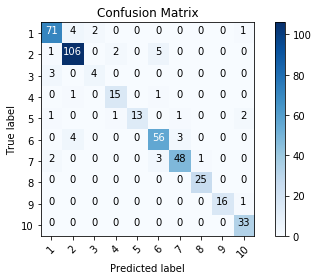

In [830]:
mlp(X_train4, y_class_train4, X_test4, y_class_test4)

Iteration 1, loss = 1.84952246
Validation score: 0.623529
Iteration 2, loss = 1.04036377
Validation score: 0.694118
Iteration 3, loss = 0.74957182
Validation score: 0.733333
Iteration 4, loss = 0.61672889
Validation score: 0.733333
Iteration 5, loss = 0.54160934
Validation score: 0.796078
Iteration 6, loss = 0.49102554
Validation score: 0.811765
Iteration 7, loss = 0.44682619
Validation score: 0.803922
Iteration 8, loss = 0.42485541
Validation score: 0.807843
Iteration 9, loss = 0.39608682
Validation score: 0.819608
Iteration 10, loss = 0.38574256
Validation score: 0.831373
Iteration 11, loss = 0.36216995
Validation score: 0.839216
Iteration 12, loss = 0.34263908
Validation score: 0.831373
Iteration 13, loss = 0.32918848
Validation score: 0.819608
Iteration 14, loss = 0.32299797
Validation score: 0.819608
Iteration 15, loss = 0.29821358
Validation score: 0.819608
Iteration 16, loss = 0.29123789
Validation score: 0.827451
Iteration 17, loss = 0.28886662
Validation score: 0.831373
Iterat

Iteration 140, loss = 0.06026752
Validation score: 0.866667
Iteration 141, loss = 0.04807923
Validation score: 0.858824
Iteration 142, loss = 0.03883566
Validation score: 0.878431
Iteration 143, loss = 0.03841724
Validation score: 0.878431
Iteration 144, loss = 0.03689583
Validation score: 0.874510
Iteration 145, loss = 0.04072208
Validation score: 0.878431
Iteration 146, loss = 0.04797118
Validation score: 0.886275
Iteration 147, loss = 0.05712146
Validation score: 0.886275
Iteration 148, loss = 0.04026439
Validation score: 0.870588
Iteration 149, loss = 0.05461291
Validation score: 0.862745
Iteration 150, loss = 0.04898721
Validation score: 0.874510
Iteration 151, loss = 0.09250321
Validation score: 0.878431
Iteration 152, loss = 0.06245390
Validation score: 0.862745
Iteration 153, loss = 0.05449875
Validation score: 0.886275
Iteration 154, loss = 0.08915454
Validation score: 0.866667
Iteration 155, loss = 0.05974944
Validation score: 0.882353
Iteration 156, loss = 0.04883797
Validat

Iteration 10, loss = 0.44288929
Validation score: 0.808824
Iteration 11, loss = 0.42130598
Validation score: 0.823529
Iteration 12, loss = 0.40776179
Validation score: 0.848039
Iteration 13, loss = 0.39141639
Validation score: 0.818627
Iteration 14, loss = 0.37279181
Validation score: 0.838235
Iteration 15, loss = 0.36401374
Validation score: 0.838235
Iteration 16, loss = 0.35290493
Validation score: 0.848039
Iteration 17, loss = 0.33437854
Validation score: 0.838235
Iteration 18, loss = 0.32482819
Validation score: 0.872549
Iteration 19, loss = 0.31264956
Validation score: 0.872549
Iteration 20, loss = 0.31330704
Validation score: 0.852941
Iteration 21, loss = 0.29170134
Validation score: 0.852941
Iteration 22, loss = 0.29730556
Validation score: 0.848039
Iteration 23, loss = 0.27993807
Validation score: 0.823529
Iteration 24, loss = 0.26427208
Validation score: 0.843137
Iteration 25, loss = 0.25124377
Validation score: 0.848039
Iteration 26, loss = 0.24613329
Validation score: 0.8431

Iteration 2, loss = 1.25559300
Validation score: 0.656863
Iteration 3, loss = 0.84101623
Validation score: 0.686275
Iteration 4, loss = 0.67095665
Validation score: 0.715686
Iteration 5, loss = 0.58353125
Validation score: 0.735294
Iteration 6, loss = 0.54565529
Validation score: 0.764706
Iteration 7, loss = 0.48831400
Validation score: 0.759804
Iteration 8, loss = 0.46235969
Validation score: 0.779412
Iteration 9, loss = 0.43503567
Validation score: 0.750000
Iteration 10, loss = 0.41560161
Validation score: 0.794118
Iteration 11, loss = 0.39464100
Validation score: 0.754902
Iteration 12, loss = 0.36759669
Validation score: 0.769608
Iteration 13, loss = 0.36654018
Validation score: 0.769608
Iteration 14, loss = 0.33558312
Validation score: 0.779412
Iteration 15, loss = 0.32257038
Validation score: 0.779412
Iteration 16, loss = 0.30721641
Validation score: 0.794118
Iteration 17, loss = 0.29520621
Validation score: 0.799020
Iteration 18, loss = 0.29953965
Validation score: 0.759804
Itera

Validation score: 0.808824
Iteration 142, loss = 0.03500032
Validation score: 0.808824
Iteration 143, loss = 0.04792950
Validation score: 0.833333
Iteration 144, loss = 0.03658962
Validation score: 0.808824
Iteration 145, loss = 0.03205923
Validation score: 0.794118
Iteration 146, loss = 0.03062572
Validation score: 0.808824
Iteration 147, loss = 0.07601210
Validation score: 0.769608
Iteration 148, loss = 0.06636442
Validation score: 0.789216
Iteration 149, loss = 0.06133592
Validation score: 0.779412
Iteration 150, loss = 0.04215821
Validation score: 0.789216
Iteration 151, loss = 0.03463454
Validation score: 0.799020
Iteration 152, loss = 0.04044956
Validation score: 0.794118
Iteration 153, loss = 0.05338862
Validation score: 0.789216
Iteration 154, loss = 0.02918942
Validation score: 0.799020
Iteration 155, loss = 0.06096135
Validation score: 0.789216
Iteration 156, loss = 0.05789921
Validation score: 0.808824
Iteration 157, loss = 0.04248834
Validation score: 0.808824
Iteration 158

Iteration 36, loss = 0.16806680
Validation score: 0.848039
Iteration 37, loss = 0.14593482
Validation score: 0.843137
Iteration 38, loss = 0.14666768
Validation score: 0.848039
Iteration 39, loss = 0.12989998
Validation score: 0.843137
Iteration 40, loss = 0.13794500
Validation score: 0.867647
Iteration 41, loss = 0.12941344
Validation score: 0.852941
Iteration 42, loss = 0.13628953
Validation score: 0.872549
Iteration 43, loss = 0.12736193
Validation score: 0.857843
Iteration 44, loss = 0.11810877
Validation score: 0.857843
Iteration 45, loss = 0.12125952
Validation score: 0.833333
Iteration 46, loss = 0.11763336
Validation score: 0.862745
Iteration 47, loss = 0.10084248
Validation score: 0.862745
Iteration 48, loss = 0.10139567
Validation score: 0.843137
Iteration 49, loss = 0.09526828
Validation score: 0.848039
Iteration 50, loss = 0.12994655
Validation score: 0.857843
Iteration 51, loss = 0.11403169
Validation score: 0.843137
Iteration 52, loss = 0.09459511
Validation score: 0.8431

Iteration 175, loss = 0.11496016
Validation score: 0.857843
Iteration 176, loss = 0.03756705
Validation score: 0.843137
Iteration 177, loss = 0.02168950
Validation score: 0.852941
Iteration 178, loss = 0.01706435
Validation score: 0.843137
Iteration 179, loss = 0.01836950
Validation score: 0.857843
Iteration 180, loss = 0.03329485
Validation score: 0.833333
Iteration 181, loss = 0.05611140
Validation score: 0.823529
Iteration 182, loss = 0.07403085
Validation score: 0.818627
Iteration 183, loss = 0.04990449
Validation score: 0.828431
Iteration 184, loss = 0.03495204
Validation score: 0.852941
Iteration 185, loss = 0.04167887
Validation score: 0.838235
Iteration 186, loss = 0.02423221
Validation score: 0.818627
Iteration 187, loss = 0.03746710
Validation score: 0.848039
Iteration 188, loss = 0.03452710
Validation score: 0.833333
Iteration 189, loss = 0.02674926
Validation score: 0.843137
Iteration 190, loss = 0.02472142
Validation score: 0.833333
Iteration 191, loss = 0.01876067
Validat

Iteration 96, loss = 0.05422081
Validation score: 0.863415
Iteration 97, loss = 0.04799188
Validation score: 0.868293
Iteration 98, loss = 0.06606141
Validation score: 0.873171
Iteration 99, loss = 0.04694090
Validation score: 0.878049
Iteration 100, loss = 0.07933009
Validation score: 0.863415
Iteration 101, loss = 0.04305877
Validation score: 0.878049
Iteration 102, loss = 0.04912322
Validation score: 0.873171
Iteration 103, loss = 0.03917381
Validation score: 0.858537
Iteration 104, loss = 0.04266192
Validation score: 0.848780
Iteration 105, loss = 0.03834284
Validation score: 0.853659
Iteration 106, loss = 0.08088329
Validation score: 0.882927
Iteration 107, loss = 0.05240470
Validation score: 0.882927
Iteration 108, loss = 0.09100108
Validation score: 0.853659
Iteration 109, loss = 0.03507377
Validation score: 0.843902
Iteration 110, loss = 0.03584421
Validation score: 0.858537
Iteration 111, loss = 0.04240130
Validation score: 0.829268
Iteration 112, loss = 0.03644712
Validation 

Iteration 47, loss = 0.11875945
Validation score: 0.824390
Iteration 48, loss = 0.10865567
Validation score: 0.839024
Iteration 49, loss = 0.12856025
Validation score: 0.858537
Iteration 50, loss = 0.10966488
Validation score: 0.839024
Iteration 51, loss = 0.10632916
Validation score: 0.858537
Iteration 52, loss = 0.10717847
Validation score: 0.834146
Iteration 53, loss = 0.09677998
Validation score: 0.824390
Iteration 54, loss = 0.10220602
Validation score: 0.824390
Iteration 55, loss = 0.09375166
Validation score: 0.829268
Iteration 56, loss = 0.11279355
Validation score: 0.834146
Iteration 57, loss = 0.10309621
Validation score: 0.839024
Iteration 58, loss = 0.12943167
Validation score: 0.843902
Iteration 59, loss = 0.09062643
Validation score: 0.853659
Iteration 60, loss = 0.08433539
Validation score: 0.858537
Iteration 61, loss = 0.08566289
Validation score: 0.848780
Iteration 62, loss = 0.08163651
Validation score: 0.848780
Iteration 63, loss = 0.08496063
Validation score: 0.8536

Iteration 185, loss = 0.04999638
Validation score: 0.858537
Iteration 186, loss = 0.02884153
Validation score: 0.853659
Iteration 187, loss = 0.01854209
Validation score: 0.843902
Iteration 188, loss = 0.01713510
Validation score: 0.853659
Iteration 189, loss = 0.01685087
Validation score: 0.843902
Iteration 190, loss = 0.01618518
Validation score: 0.853659
Iteration 191, loss = 0.02297861
Validation score: 0.868293
Iteration 192, loss = 0.01331309
Validation score: 0.839024
Iteration 193, loss = 0.01804411
Validation score: 0.843902
Iteration 194, loss = 0.04692485
Validation score: 0.843902
Iteration 195, loss = 0.03538689
Validation score: 0.853659
Iteration 196, loss = 0.01721586
Validation score: 0.834146
Iteration 197, loss = 0.02022062
Validation score: 0.848780
Iteration 198, loss = 0.02205269
Validation score: 0.843902
Iteration 199, loss = 0.01850586
Validation score: 0.853659
Iteration 200, loss = 0.02029334
Validation score: 0.843902
Iteration 201, loss = 0.02241031
Validat

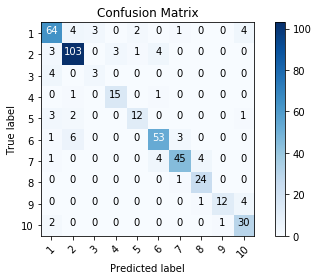

In [826]:
mlp(X_train1, y_class_train, X_test1, y_class_test)

Iteration 1, loss = 0.52194903
Validation score: 0.858824
Iteration 2, loss = 0.30869449
Validation score: 0.894118
Iteration 3, loss = 0.24592640
Validation score: 0.898039
Iteration 4, loss = 0.21768781
Validation score: 0.890196
Iteration 5, loss = 0.20059241
Validation score: 0.898039
Iteration 6, loss = 0.19814172
Validation score: 0.913725
Iteration 7, loss = 0.17661052
Validation score: 0.909804
Iteration 8, loss = 0.16473243
Validation score: 0.909804
Iteration 9, loss = 0.16177491
Validation score: 0.921569
Iteration 10, loss = 0.14650629
Validation score: 0.921569
Iteration 11, loss = 0.14016508
Validation score: 0.894118
Iteration 12, loss = 0.13001369
Validation score: 0.909804
Iteration 13, loss = 0.12488073
Validation score: 0.925490
Iteration 14, loss = 0.11490183
Validation score: 0.894118
Iteration 15, loss = 0.11371215
Validation score: 0.913725
Iteration 16, loss = 0.11621084
Validation score: 0.901961
Iteration 17, loss = 0.10426751
Validation score: 0.901961
Iterat

Iteration 140, loss = 0.01583445
Validation score: 0.909804
Iteration 141, loss = 0.01087866
Validation score: 0.909804
Iteration 142, loss = 0.02788551
Validation score: 0.909804
Iteration 143, loss = 0.01540780
Validation score: 0.905882
Iteration 144, loss = 0.01169833
Validation score: 0.905882
Iteration 145, loss = 0.02791209
Validation score: 0.898039
Iteration 146, loss = 0.03910704
Validation score: 0.898039
Iteration 147, loss = 0.03222587
Validation score: 0.909804
Iteration 148, loss = 0.03016030
Validation score: 0.917647
Iteration 149, loss = 0.04234725
Validation score: 0.921569
Iteration 150, loss = 0.03096889
Validation score: 0.913725
Iteration 151, loss = 0.01111903
Validation score: 0.921569
Iteration 152, loss = 0.01253187
Validation score: 0.917647
Iteration 153, loss = 0.01574467
Validation score: 0.913725
Iteration 154, loss = 0.01351178
Validation score: 0.909804
Iteration 155, loss = 0.02027178
Validation score: 0.913725
Iteration 156, loss = 0.01347440
Validat

Iteration 7, loss = 0.19242138
Validation score: 0.901961
Iteration 8, loss = 0.18370858
Validation score: 0.931373
Iteration 9, loss = 0.16572364
Validation score: 0.916667
Iteration 10, loss = 0.15975791
Validation score: 0.931373
Iteration 11, loss = 0.15276164
Validation score: 0.921569
Iteration 12, loss = 0.14564087
Validation score: 0.911765
Iteration 13, loss = 0.14405374
Validation score: 0.877451
Iteration 14, loss = 0.13158417
Validation score: 0.911765
Iteration 15, loss = 0.13687180
Validation score: 0.916667
Iteration 16, loss = 0.12243449
Validation score: 0.926471
Iteration 17, loss = 0.11568209
Validation score: 0.926471
Iteration 18, loss = 0.11192090
Validation score: 0.941176
Iteration 19, loss = 0.10729519
Validation score: 0.936275
Iteration 20, loss = 0.10726871
Validation score: 0.926471
Iteration 21, loss = 0.09491966
Validation score: 0.936275
Iteration 22, loss = 0.09937556
Validation score: 0.911765
Iteration 23, loss = 0.09126333
Validation score: 0.921569


Iteration 1, loss = 0.55359991
Validation score: 0.857843
Iteration 2, loss = 0.34764926
Validation score: 0.848039
Iteration 3, loss = 0.26799754
Validation score: 0.892157
Iteration 4, loss = 0.23632616
Validation score: 0.906863
Iteration 5, loss = 0.21983166
Validation score: 0.892157
Iteration 6, loss = 0.19289127
Validation score: 0.897059
Iteration 7, loss = 0.18779637
Validation score: 0.906863
Iteration 8, loss = 0.16811666
Validation score: 0.897059
Iteration 9, loss = 0.15678793
Validation score: 0.901961
Iteration 10, loss = 0.15846970
Validation score: 0.901961
Iteration 11, loss = 0.15001934
Validation score: 0.892157
Iteration 12, loss = 0.14439231
Validation score: 0.897059
Iteration 13, loss = 0.13769891
Validation score: 0.887255
Iteration 14, loss = 0.13448338
Validation score: 0.906863
Iteration 15, loss = 0.13341970
Validation score: 0.867647
Iteration 16, loss = 0.13869398
Validation score: 0.901961
Iteration 17, loss = 0.11982036
Validation score: 0.906863
Iterat

Validation score: 0.936275
Iteration 142, loss = 0.01490053
Validation score: 0.936275
Iteration 143, loss = 0.01277247
Validation score: 0.926471
Iteration 144, loss = 0.01597452
Validation score: 0.926471
Iteration 145, loss = 0.02258481
Validation score: 0.921569
Iteration 146, loss = 0.01531191
Validation score: 0.911765
Iteration 147, loss = 0.02287267
Validation score: 0.931373
Iteration 148, loss = 0.01611572
Validation score: 0.911765
Iteration 149, loss = 0.03484918
Validation score: 0.906863
Iteration 150, loss = 0.02654607
Validation score: 0.921569
Iteration 151, loss = 0.01585400
Validation score: 0.941176
Iteration 152, loss = 0.01117207
Validation score: 0.931373
Iteration 153, loss = 0.05789938
Validation score: 0.926471
Iteration 154, loss = 0.01739126
Validation score: 0.926471
Iteration 155, loss = 0.02074289
Validation score: 0.926471
Iteration 156, loss = 0.01279988
Validation score: 0.931373
Iteration 157, loss = 0.00992275
Validation score: 0.926471
Iteration 158

Iteration 80, loss = 0.03107975
Validation score: 0.936275
Iteration 81, loss = 0.06502150
Validation score: 0.931373
Iteration 82, loss = 0.03413934
Validation score: 0.926471
Iteration 83, loss = 0.02188469
Validation score: 0.921569
Iteration 84, loss = 0.02592304
Validation score: 0.926471
Iteration 85, loss = 0.02202575
Validation score: 0.931373
Iteration 86, loss = 0.01623493
Validation score: 0.931373
Iteration 87, loss = 0.01788460
Validation score: 0.916667
Iteration 88, loss = 0.02759609
Validation score: 0.926471
Iteration 89, loss = 0.04869470
Validation score: 0.901961
Iteration 90, loss = 0.05523890
Validation score: 0.936275
Iteration 91, loss = 0.02013917
Validation score: 0.926471
Iteration 92, loss = 0.02279505
Validation score: 0.916667
Iteration 93, loss = 0.02209361
Validation score: 0.936275
Iteration 94, loss = 0.01825756
Validation score: 0.936275
Iteration 95, loss = 0.02578409
Validation score: 0.906863
Iteration 96, loss = 0.03282428
Validation score: 0.9215

Iteration 77, loss = 0.02289710
Validation score: 0.926471
Iteration 78, loss = 0.03270777
Validation score: 0.906863
Iteration 79, loss = 0.04840965
Validation score: 0.906863
Iteration 80, loss = 0.03046721
Validation score: 0.921569
Iteration 81, loss = 0.03500800
Validation score: 0.926471
Iteration 82, loss = 0.02863011
Validation score: 0.921569
Iteration 83, loss = 0.02267930
Validation score: 0.921569
Iteration 84, loss = 0.04693013
Validation score: 0.916667
Iteration 85, loss = 0.04037676
Validation score: 0.926471
Iteration 86, loss = 0.02221011
Validation score: 0.936275
Iteration 87, loss = 0.02591820
Validation score: 0.916667
Iteration 88, loss = 0.02637901
Validation score: 0.921569
Iteration 89, loss = 0.02016378
Validation score: 0.906863
Iteration 90, loss = 0.03268050
Validation score: 0.921569
Iteration 91, loss = 0.02848649
Validation score: 0.916667
Iteration 92, loss = 0.03113851
Validation score: 0.936275
Iteration 93, loss = 0.02537490
Validation score: 0.9264

Validation score: 0.921569
Iteration 215, loss = 0.01010843
Validation score: 0.941176
Iteration 216, loss = 0.00909133
Validation score: 0.936275
Iteration 217, loss = 0.00915531
Validation score: 0.926471
Iteration 218, loss = 0.00847991
Validation score: 0.931373
Iteration 219, loss = 0.00964787
Validation score: 0.931373
Iteration 220, loss = 0.00829721
Validation score: 0.921569
Iteration 221, loss = 0.01058341
Validation score: 0.926471
Iteration 222, loss = 0.01244208
Validation score: 0.921569
Iteration 223, loss = 0.01175250
Validation score: 0.926471
Iteration 224, loss = 0.00809683
Validation score: 0.926471
Iteration 225, loss = 0.00883014
Validation score: 0.926471
Iteration 226, loss = 0.00838839
Validation score: 0.936275
Iteration 227, loss = 0.00822972
Validation score: 0.916667
Iteration 228, loss = 0.00940514
Validation score: 0.921569
Iteration 229, loss = 0.00906024
Validation score: 0.926471
Iteration 230, loss = 0.00789108
Validation score: 0.926471
Iteration 231

Iteration 66, loss = 0.02386479
Validation score: 0.936585
Iteration 67, loss = 0.02057425
Validation score: 0.931707
Iteration 68, loss = 0.02078400
Validation score: 0.936585
Iteration 69, loss = 0.01454379
Validation score: 0.941463
Iteration 70, loss = 0.01402192
Validation score: 0.941463
Iteration 71, loss = 0.02144870
Validation score: 0.926829
Iteration 72, loss = 0.04118186
Validation score: 0.936585
Iteration 73, loss = 0.01308805
Validation score: 0.941463
Iteration 74, loss = 0.01500506
Validation score: 0.941463
Iteration 75, loss = 0.02271848
Validation score: 0.931707
Iteration 76, loss = 0.01832423
Validation score: 0.941463
Iteration 77, loss = 0.03044957
Validation score: 0.917073
Iteration 78, loss = 0.01889716
Validation score: 0.936585
Iteration 79, loss = 0.02008971
Validation score: 0.926829
Iteration 80, loss = 0.04169929
Validation score: 0.936585
Iteration 81, loss = 0.03933981
Validation score: 0.941463
Iteration 82, loss = 0.01534703
Validation score: 0.9365

Iteration 204, loss = 0.02181473
Validation score: 0.956098
Iteration 205, loss = 0.00921757
Validation score: 0.951220
Iteration 206, loss = 0.00805966
Validation score: 0.960976
Iteration 207, loss = 0.00608248
Validation score: 0.951220
Iteration 208, loss = 0.00465074
Validation score: 0.956098
Iteration 209, loss = 0.00469689
Validation score: 0.956098
Iteration 210, loss = 0.00383259
Validation score: 0.956098
Iteration 211, loss = 0.00578117
Validation score: 0.951220
Iteration 212, loss = 0.00430646
Validation score: 0.956098
Iteration 213, loss = 0.00892777
Validation score: 0.946341
Iteration 214, loss = 0.00858924
Validation score: 0.941463
Iteration 215, loss = 0.02501220
Validation score: 0.926829
Iteration 216, loss = 0.07184988
Validation score: 0.936585
Iteration 217, loss = 0.02061974
Validation score: 0.956098
Iteration 218, loss = 0.00824515
Validation score: 0.960976
Iteration 219, loss = 0.00824413
Validation score: 0.956098
Iteration 220, loss = 0.00500448
Validat

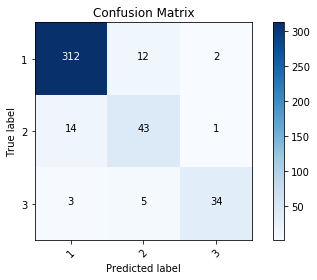

In [831]:
mlp(X_train2, y_nsp_train, X_test2, y_nsp_test)

Iteration 1, loss = 0.43901381
Validation score: 0.933333
Iteration 2, loss = 0.18527526
Validation score: 0.960784
Iteration 3, loss = 0.13043129
Validation score: 0.952941
Iteration 4, loss = 0.10002559
Validation score: 0.960784
Iteration 5, loss = 0.08485965
Validation score: 0.952941
Iteration 6, loss = 0.06702086
Validation score: 0.952941
Iteration 7, loss = 0.05112302
Validation score: 0.964706
Iteration 8, loss = 0.05639701
Validation score: 0.960784
Iteration 9, loss = 0.04520731
Validation score: 0.952941
Iteration 10, loss = 0.03894007
Validation score: 0.964706
Iteration 11, loss = 0.03432050
Validation score: 0.960784
Iteration 12, loss = 0.03420097
Validation score: 0.956863
Iteration 13, loss = 0.03894639
Validation score: 0.956863
Iteration 14, loss = 0.03176947
Validation score: 0.960784
Iteration 15, loss = 0.02993204
Validation score: 0.964706
Iteration 16, loss = 0.02582335
Validation score: 0.972549
Iteration 17, loss = 0.02733475
Validation score: 0.968627
Iterat

Iteration 6, loss = 0.06904851
Validation score: 0.946078
Iteration 7, loss = 0.06409657
Validation score: 0.955882
Iteration 8, loss = 0.05937568
Validation score: 0.946078
Iteration 9, loss = 0.05291688
Validation score: 0.946078
Iteration 10, loss = 0.04277937
Validation score: 0.950980
Iteration 11, loss = 0.03942291
Validation score: 0.946078
Iteration 12, loss = 0.03937056
Validation score: 0.955882
Iteration 13, loss = 0.03053429
Validation score: 0.946078
Iteration 14, loss = 0.03310845
Validation score: 0.946078
Iteration 15, loss = 0.03268485
Validation score: 0.946078
Iteration 16, loss = 0.05396494
Validation score: 0.926471
Iteration 17, loss = 0.03675721
Validation score: 0.946078
Iteration 18, loss = 0.02721448
Validation score: 0.946078
Iteration 19, loss = 0.02215955
Validation score: 0.946078
Iteration 20, loss = 0.01973385
Validation score: 0.950980
Iteration 21, loss = 0.01795051
Validation score: 0.955882
Iteration 22, loss = 0.02103978
Validation score: 0.950980
I

Iteration 146, loss = 0.00111930
Validation score: 0.960784
Iteration 147, loss = 0.00111625
Validation score: 0.965686
Iteration 148, loss = 0.00110584
Validation score: 0.960784
Iteration 149, loss = 0.00109928
Validation score: 0.965686
Iteration 150, loss = 0.00109572
Validation score: 0.965686
Iteration 151, loss = 0.00113428
Validation score: 0.960784
Iteration 152, loss = 0.00108339
Validation score: 0.960784
Iteration 153, loss = 0.00106991
Validation score: 0.965686
Iteration 154, loss = 0.00106490
Validation score: 0.965686
Iteration 155, loss = 0.00106793
Validation score: 0.965686
Iteration 156, loss = 0.00109670
Validation score: 0.960784
Iteration 157, loss = 0.00267292
Validation score: 0.926471
Iteration 158, loss = 0.11814095
Validation score: 0.941176
Iteration 159, loss = 0.00817391
Validation score: 0.955882
Iteration 160, loss = 0.01137283
Validation score: 0.955882
Iteration 161, loss = 0.01140533
Validation score: 0.960784
Iteration 162, loss = 0.00405248
Validat

Iteration 284, loss = 0.00095734
Validation score: 0.960784
Iteration 285, loss = 0.00095563
Validation score: 0.960784
Iteration 286, loss = 0.00094970
Validation score: 0.960784
Iteration 287, loss = 0.00095370
Validation score: 0.960784
Iteration 288, loss = 0.00098062
Validation score: 0.960784
Iteration 289, loss = 0.00095086
Validation score: 0.965686
Iteration 290, loss = 0.00093548
Validation score: 0.965686
Iteration 291, loss = 0.00092775
Validation score: 0.965686
Iteration 292, loss = 0.00092406
Validation score: 0.965686
Iteration 293, loss = 0.00091647
Validation score: 0.965686
Iteration 294, loss = 0.00091389
Validation score: 0.965686
Iteration 295, loss = 0.01167143
Validation score: 0.950980
Iteration 296, loss = 0.07728326
Validation score: 0.955882
Iteration 297, loss = 0.02033081
Validation score: 0.955882
Iteration 298, loss = 0.01407432
Validation score: 0.960784
Iteration 299, loss = 0.00548198
Validation score: 0.960784
Iteration 300, loss = 0.00360639
Validat

Validation score: 0.965686
Iteration 422, loss = 0.04140058
Validation score: 0.960784
Iteration 423, loss = 0.02567946
Validation score: 0.955882
Iteration 424, loss = 0.00952999
Validation score: 0.970588
Iteration 425, loss = 0.01320218
Validation score: 0.965686
Iteration 426, loss = 0.00187629
Validation score: 0.965686
Iteration 427, loss = 0.00156194
Validation score: 0.965686
Iteration 428, loss = 0.00125379
Validation score: 0.965686
Iteration 429, loss = 0.00115214
Validation score: 0.965686
Iteration 430, loss = 0.00109005
Validation score: 0.965686
Iteration 431, loss = 0.00104901
Validation score: 0.965686
Iteration 432, loss = 0.00101289
Validation score: 0.965686
Iteration 433, loss = 0.00098598
Validation score: 0.965686
Iteration 434, loss = 0.00096504
Validation score: 0.965686
Iteration 435, loss = 0.00094958
Validation score: 0.965686
Iteration 436, loss = 0.00093479
Validation score: 0.965686
Iteration 437, loss = 0.00092381
Validation score: 0.965686
Iteration 438

Iteration 79, loss = 0.00287645
Validation score: 0.960784
Iteration 80, loss = 0.00362580
Validation score: 0.955882
Iteration 81, loss = 0.00668096
Validation score: 0.950980
Iteration 82, loss = 0.01923177
Validation score: 0.960784
Iteration 83, loss = 0.05154285
Validation score: 0.960784
Iteration 84, loss = 0.01212275
Validation score: 0.955882
Iteration 85, loss = 0.01176965
Validation score: 0.955882
Iteration 86, loss = 0.00502676
Validation score: 0.960784
Iteration 87, loss = 0.00427104
Validation score: 0.960784
Iteration 88, loss = 0.00590834
Validation score: 0.955882
Iteration 89, loss = 0.00309248
Validation score: 0.955882
Iteration 90, loss = 0.00478941
Validation score: 0.955882
Iteration 91, loss = 0.00979640
Validation score: 0.955882
Iteration 92, loss = 0.00478282
Validation score: 0.955882
Iteration 93, loss = 0.00323477
Validation score: 0.955882
Iteration 94, loss = 0.01153704
Validation score: 0.946078
Iteration 95, loss = 0.02494650
Validation score: 0.9509

Validation score: 0.975490
Iteration 57, loss = 0.00255749
Validation score: 0.970588
Iteration 58, loss = 0.00353514
Validation score: 0.970588
Iteration 59, loss = 0.00561347
Validation score: 0.970588
Iteration 60, loss = 0.01592000
Validation score: 0.941176
Iteration 61, loss = 0.04129294
Validation score: 0.975490
Iteration 62, loss = 0.00955629
Validation score: 0.975490
Iteration 63, loss = 0.00662687
Validation score: 0.975490
Iteration 64, loss = 0.00287138
Validation score: 0.970588
Iteration 65, loss = 0.00228602
Validation score: 0.980392
Iteration 66, loss = 0.00157991
Validation score: 0.980392
Iteration 67, loss = 0.00149785
Validation score: 0.980392
Iteration 68, loss = 0.00147105
Validation score: 0.980392
Iteration 69, loss = 0.00143568
Validation score: 0.980392
Iteration 70, loss = 0.00137662
Validation score: 0.980392
Iteration 71, loss = 0.00135707
Validation score: 0.980392
Iteration 72, loss = 0.00132412
Validation score: 0.980392
Iteration 73, loss = 0.001319

Validation score: 0.965686
Iteration 196, loss = 0.01549150
Validation score: 0.965686
Iteration 197, loss = 0.00760670
Validation score: 0.965686
Iteration 198, loss = 0.00165303
Validation score: 0.965686
Iteration 199, loss = 0.00146018
Validation score: 0.965686
Iteration 200, loss = 0.00134030
Validation score: 0.965686
Iteration 201, loss = 0.00127989
Validation score: 0.965686
Iteration 202, loss = 0.00123894
Validation score: 0.965686
Iteration 203, loss = 0.00120803
Validation score: 0.965686
Iteration 204, loss = 0.00117607
Validation score: 0.965686
Iteration 205, loss = 0.00114942
Validation score: 0.965686
Iteration 206, loss = 0.00113435
Validation score: 0.965686
Iteration 207, loss = 0.00112007
Validation score: 0.965686
Iteration 208, loss = 0.00110819
Validation score: 0.965686
Iteration 209, loss = 0.00109794
Validation score: 0.965686
Iteration 210, loss = 0.00108842
Validation score: 0.965686
Iteration 211, loss = 0.00107908
Validation score: 0.965686
Iteration 212

Iteration 123, loss = 0.00183176
Validation score: 0.975490
Iteration 124, loss = 0.00966486
Validation score: 0.975490
Iteration 125, loss = 0.00190408
Validation score: 0.975490
Iteration 126, loss = 0.00170285
Validation score: 0.975490
Iteration 127, loss = 0.00188306
Validation score: 0.975490
Iteration 128, loss = 0.00189655
Validation score: 0.970588
Iteration 129, loss = 0.00777784
Validation score: 0.975490
Iteration 130, loss = 0.00873713
Validation score: 0.965686
Iteration 131, loss = 0.00328124
Validation score: 0.970588
Iteration 132, loss = 0.00186770
Validation score: 0.975490
Iteration 133, loss = 0.00524888
Validation score: 0.975490
Iteration 134, loss = 0.00183986
Validation score: 0.970588
Iteration 135, loss = 0.00180142
Validation score: 0.975490
Iteration 136, loss = 0.00259579
Validation score: 0.975490
Iteration 137, loss = 0.00189896
Validation score: 0.970588
Iteration 138, loss = 0.00161538
Validation score: 0.970588
Iteration 139, loss = 0.01243389
Validat

Iteration 40, loss = 0.01106832
Validation score: 0.956098
Iteration 41, loss = 0.00855278
Validation score: 0.951220
Iteration 42, loss = 0.02190672
Validation score: 0.960976
Iteration 43, loss = 0.00959666
Validation score: 0.951220
Iteration 44, loss = 0.00724558
Validation score: 0.960976
Iteration 45, loss = 0.00998162
Validation score: 0.960976
Iteration 46, loss = 0.02046117
Validation score: 0.965854
Iteration 47, loss = 0.01307874
Validation score: 0.951220
Iteration 48, loss = 0.00391652
Validation score: 0.951220
Iteration 49, loss = 0.00535097
Validation score: 0.956098
Iteration 50, loss = 0.01201554
Validation score: 0.956098
Iteration 51, loss = 0.00568483
Validation score: 0.951220
Iteration 52, loss = 0.00228118
Validation score: 0.951220
Iteration 53, loss = 0.00197622
Validation score: 0.951220
Iteration 54, loss = 0.00238363
Validation score: 0.956098
Iteration 55, loss = 0.00705236
Validation score: 0.956098
Iteration 56, loss = 0.01545780
Validation score: 0.9560

 test accuracy = 96.0093896713615


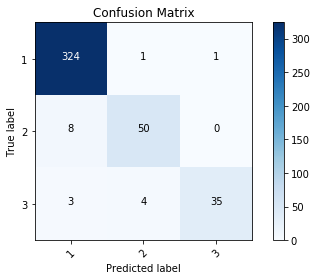

In [832]:
mlp(X_train3, y_nsp_train3, X_test3, y_nsp_test3)

In [19]:
cv1_MLP = [0.87209302, 0.84795322, 0.83235294, 0.84955752, 0.82686567]
cv2_MLP = [0.92961877, 0.94428152, 0.9,        0.92058824, 0.93195266]
cv3_MLP = [0.96480938, 0.97067449, 0.95588235, 0.96764706, 0.96745562] 
cv4_MLP = [0.90988372, 0.89181287, 0.89411765, 0.8879056,  0.86567164] 

In [20]:
cv1_LR = [0.82848837, 0.82163743, 0.82941176, 0.86725664, 0.80597015]
cv2_LR = [0.89442815, 0.8914956,  0.86176471, 0.91176471 ,0.90532544]
cv3_LR = [0.95307918 ,0.95894428, 0.95       ,0.96176471 ,0.95857988]
cv4_LR = [0.90406977, 0.90350877, 0.90294118 ,0.92625369, 0.88656716]

In [21]:
cv1_KNN = [0.8255814,  0.80409357, 0.77941176, 0.76106195, 0.78507463]
cv2_KNN = [0.94134897, 0.92668622, 0.90588235, 0.92352941, 0.90532544]
cv3_KNN = [0.97653959, 0.95894428, 0.95,       0.96470588, 0.95857988]
cv4_KNN = [0.86337209, 0.84502924, 0.82941176, 0.83775811 ,0.83283582]

# Ensemble 

In [71]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

#creating the gradient boosting classifier with the best parameters
clf1 = GradientBoostingClassifier(n_estimators=82, 
                                  subsample=1, 
                                  max_depth=3, 
                                  min_samples_split=3, 
                                  min_samples_leaf=3)

#creating the random forest classifier with the best parameters
clf2 = RandomForestClassifier(n_estimators=800, max_features='sqrt', max_depth=90, min_samples_split=5 )

#creating support vector classifier with the best parameters
clf3 = SVC(C=200, gamma=0.01, probability=True)

#creating the voting classifier with soft voting
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[4,2,1])

#Computing cross validation scores for all the models with their mean and standard devaition
for clf, label in zip([clf1, clf2, clf3, eclf], ['Gradient Boosting', 'Random Forest', 'SVM', 'Ensemble']):
    scores = cross_val_score(clf, X_train1, y_class_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.5f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label), scores)
    


Accuracy: 0.90168 (+/- 0.02) [Gradient Boosting] [0.91860465 0.9122807  0.86176471 0.92920354 0.88656716]
Accuracy: 0.89459 (+/- 0.02) [Random Forest] [0.91569767 0.89473684 0.87941176 0.91445428 0.86865672]
Accuracy: 0.85989 (+/- 0.01) [SVM] [0.88081395 0.85964912 0.85588235 0.86430678 0.83880597]
Accuracy: 0.90169 (+/- 0.03) [Ensemble] [0.92732558 0.90350877 0.85882353 0.92625369 0.89253731]


0.8896713615023474

In [70]:

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

clf1 = GradientBoostingClassifier(n_estimators=82, subsample=0.9, max_depth=3, min_samples_split=3, min_samples_leaf=3)
clf2 = RandomForestClassifier(n_estimators=400, max_features='auto', max_depth=90, min_samples_split=5 )
clf3 = SVC(C=30, gamma=0.05, kernel='rbf', probability=True)
clf4 = MLPClassifier(activation='relu', hidden_layer_sizes=(30,30,30,30), max_iter=500, alpha=0.0001, batch_size=8,
                     solver='adam', verbose=0,  random_state=22, tol=0.00000000000000000001, validation_fraction=0.15, early_stopping=True, n_iter_no_change=100)
#clf5 = AdaBoostClassifier(n_estimators=800)    

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[2,2,1])

for clf, label in zip([clf1, clf2, clf3, eclf], ['Gradient Boosting', 'Random Forest', 'SVM', 'Ensemble']):
    scores = cross_val_score(clf, X_train2, y_nsp_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.5f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label), scores)
    
eclf.fit(X_train2, y_nsp_train).score(X_test2, y_nsp_test)

Accuracy: 0.95587 (+/- 0.01) [Gradient Boosting] [0.96187683 0.95894428 0.94117647 0.97058824 0.94674556]
Accuracy: 0.95117 (+/- 0.01) [Random Forest] [0.95307918 0.95307918 0.93529412 0.96764706 0.94674556]
Accuracy: 0.93057 (+/- 0.01) [SVM] [0.93255132 0.94134897 0.92941176 0.92647059 0.92307692]
Accuracy: 0.95589 (+/- 0.01) [Ensemble] [0.96480938 0.95307918 0.93235294 0.96764706 0.96153846]


0.9483568075117371

In [73]:

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

clf1 = GradientBoostingClassifier(n_estimators=81, subsample=1, max_depth=2, min_samples_split=4, min_samples_leaf=1)
clf2 = RandomForestClassifier(n_estimators=600, max_features='sqrt', max_depth=60, min_samples_split=5)
clf3 = SVC(C=125, gamma=0.015, kernel='rbf', probability=True)
#clf4 = MLPClassifier(activation='relu', hidden_layer_sizes=(30,30,30,30), max_iter=500, alpha=0.0001, batch_size=8,
                     #solver='adam', verbose=0,  random_state=22, tol=0.00000000000000000001, validation_fraction=0.15, early_stopping=True, n_iter_no_change=100)
#clf5 = AdaBoostClassifier(n_estimators=800)    

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[4,4,0])

for clf, label in zip([clf1, clf2, clf3, eclf], ['Gradient Boosting', 'Random Forest', 'SVM', 'Ensemble']):
    scores = cross_val_score(clf, X_train3, y_nsp_train3, cv=5, scoring='accuracy')
    print("Accuracy: %0.5f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label), scores)
    
eclf.fit(X_train3, y_nsp_train3).score(X_test3, y_nsp_test3)

Accuracy: 0.98941 (+/- 0.00) [Gradient Boosting] [0.98826979 0.99120235 0.98823529 0.99117647 0.98816568]
Accuracy: 0.98060 (+/- 0.01) [Random Forest] [0.98240469 0.97947214 0.97058824 0.98235294 0.98816568]
Accuracy: 0.97057 (+/- 0.01) [SVM] [0.97653959 0.97947214 0.96764706 0.96470588 0.96449704]
Accuracy: 0.98765 (+/- 0.00) [Ensemble] [0.98533724 0.99120235 0.98529412 0.98823529 0.98816568]


0.9859154929577465

In [75]:

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

clf1 = GradientBoostingClassifier(n_estimators=82, subsample=1, max_depth=3, min_samples_split=3, min_samples_leaf=3)
clf2 = RandomForestClassifier(n_estimators=1520, max_features='sqrt', max_depth=22, min_samples_split=2)
clf3 = SVC(C=150, gamma=0.01, kernel='rbf', probability=True)
clf4 = MLPClassifier(activation='relu', hidden_layer_sizes=(30,30,30,30), max_iter=500, alpha=0.0001, batch_size=8,
                     solver='adam', verbose=0,  random_state=22, tol=0.00000000000000000001, validation_fraction=0.15, early_stopping=True, n_iter_no_change=100)
#clf5 = AdaBoostClassifier(n_estimators=800)    

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[2,2,1])

for clf, label in zip([clf1, clf2, clf3, eclf], ['Gradient Boosting', 'Random Forest', 'SVM', 'Ensemble']):
    scores = cross_val_score(clf, X_train4, y_class_train4, cv=5, scoring='accuracy')
    print("Accuracy: %0.5f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label), scores)
    
    
eclf.fit(X_train4, y_class_train4).score(X_test4, y_class_test4)

Accuracy: 0.92700 (+/- 0.01) [Gradient Boosting] [0.93895349 0.93567251 0.90588235 0.9380531  0.91641791]
Accuracy: 0.92520 (+/- 0.01) [Random Forest] [0.94767442 0.92690058 0.90882353 0.93215339 0.91044776]
Accuracy: 0.90752 (+/- 0.02) [SVM] [0.93604651 0.90643275 0.89411765 0.91445428 0.88656716]
Accuracy: 0.92697 (+/- 0.01) [Ensemble] [0.94476744 0.92982456 0.91176471 0.9380531  0.91044776]


0.9225352112676056

In [23]:
cv1_Ensemble = [0.92151163, 0.90350877, 0.86470588, 0.93510324, 0.89552239]
cv2_Ensemble = [0.96480938, 0.95307918, 0.93529412, 0.96470588, 0.95857988]
cv3_Ensemble = [0.98826979, 0.9941349,  0.98235294, 0.98823529, 0.98816568]
cv4_Ensemble = [0.94767442, 0.92982456, 0.90882353, 0.9380531,  0.92238806]

# Visualizing Results

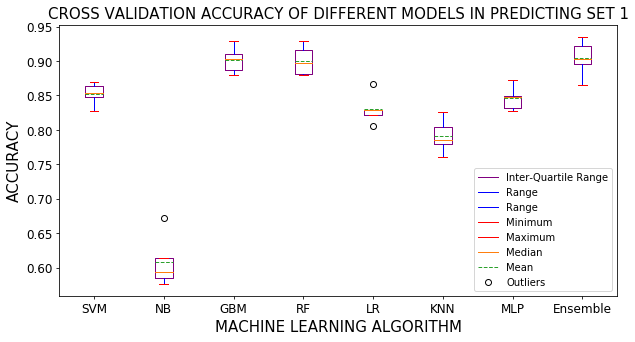

In [24]:
plt.figure(figsize=(10,5))

#create a box plot of the cross validation results of every model
plt.boxplot([cv1_svm, cv1_NB, cv1_GB, cv1_RF, cv1_LR, cv1_KNN, cv1_MLP, cv1_Ensemble],
            boxprops={'color':'purple'},
            whiskerprops={'color':'blue'},
            capprops={'color':'red'},
            showmeans=True,
            widths=0.25,
            meanline=True)

plt.xlabel("MACHINE LEARNING ALGORITHM", fontsize=15)
plt.ylabel('ACCURACY', fontsize=15)
plt.title('CROSS VALIDATION ACCURACY OF DIFFERENT MODELS IN PREDICTING SET 1', fontsize=15)

#get current axis
ax = plt.gca()

#rename the xtick labels and change the font size
c=['SVM','NB','GBM','RF','LR','KNN','MLP', 'Ensemble']
ax.set_xticklabels(c)
ax.tick_params(axis=u'both', which=u'both',length=3, labelsize=12)

#create a legend
ax.legend(['Inter-Quartile Range', 'Range', 'Range','Minimum','Maximum','Median','Mean','Outliers'])
plt.savefig('set 1 cross validation.png')

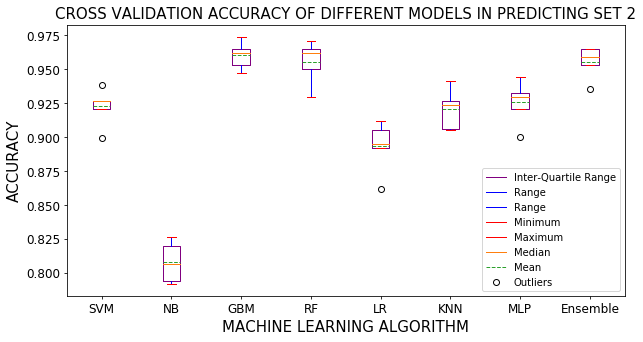

In [25]:
plt.figure(figsize=(10,5))
plt.boxplot([cv2_svm, cv2_NB, cv2_GB, cv2_RF, cv2_LR, cv2_KNN, cv2_MLP, cv2_Ensemble], boxprops={'color':'purple'},whiskerprops={'color':'blue'}, capprops={'color':'red'}, showmeans=True, widths=0.25, meanline=True)

plt.xlabel("MACHINE LEARNING ALGORITHM", fontsize=15)
plt.ylabel('ACCURACY', fontsize=15)
plt.title('CROSS VALIDATION ACCURACY OF DIFFERENT MODELS IN PREDICTING SET 2', fontsize=15)

ax = plt.gca()

c=['SVM','NB','GBM','RF','LR','KNN','MLP', 'Ensemble']
ax.set_xticklabels(c)
ax.tick_params(axis=u'both', which=u'both',length=3, labelsize=12)

ax.legend(['Inter-Quartile Range', 'Range', 'Range','Minimum','Maximum','Median','Mean','Outliers'])
plt.savefig('set 2 cross validation.png')

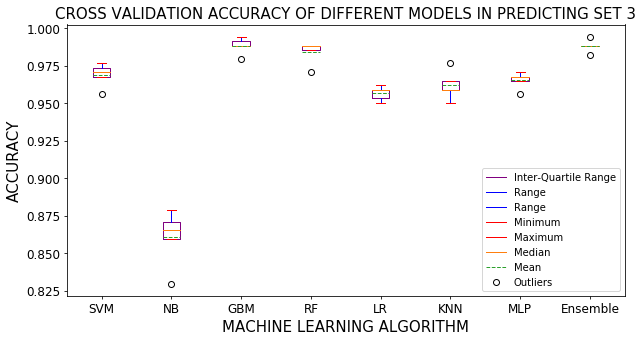

In [26]:
plt.figure(figsize=(10,5))
plt.boxplot([cv3_svm, cv3_NB, cv3_GB, cv3_RF, cv3_LR, cv3_KNN, cv3_MLP, cv3_Ensemble], boxprops={'color':'purple'},whiskerprops={'color':'blue'}, capprops={'color':'red'}, showmeans=True, widths=0.25, meanline=True)

plt.xlabel("MACHINE LEARNING ALGORITHM", fontsize=15)
plt.ylabel('ACCURACY', fontsize=15)
plt.title('CROSS VALIDATION ACCURACY OF DIFFERENT MODELS IN PREDICTING SET 3', fontsize=15)

ax = plt.gca()

c=['SVM','NB','GBM','RF','LR','KNN','MLP','Ensemble']
ax.set_xticklabels(c)
ax.tick_params(axis=u'both', which=u'both',length=3, labelsize=12)

ax.legend(['Inter-Quartile Range', 'Range', 'Range','Minimum','Maximum','Median','Mean','Outliers'])
plt.savefig('set 3 cross validation.png')

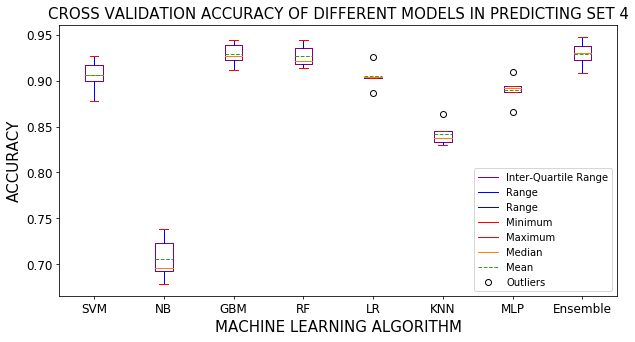

In [27]:
plt.figure(figsize=(10,5))
k =plt.boxplot([cv4_svm, cv4_NB, cv4_GB, cv4_RF, cv4_LR, cv4_KNN, cv4_MLP, cv4_Ensemble], boxprops={'color':'purple'},whiskerprops={'color':'blue'}, capprops={'color':'red'}, showmeans=True, widths=0.25, meanline=True)

plt.xlabel("MACHINE LEARNING ALGORITHM", fontsize=15)
plt.ylabel('ACCURACY', fontsize=15)
plt.title('CROSS VALIDATION ACCURACY OF DIFFERENT MODELS IN PREDICTING SET 4', fontsize=15)

ax = plt.gca()

c=['SVM','NB','GBM','RF','LR','KNN','MLP','Ensemble']
ax.set_xticklabels(c)
ax.tick_params(axis=u'both', which=u'both',length=3, labelsize=12)

ax.legend(['Inter-Quartile Range', 'Range', 'Range','Minimum','Maximum','Median','Mean','Outliers'])

#handles, labels = ax.get_legend_handles_labels()

plt.savefig('set 4 cross validation.png')